## 1.数据整理

### 载入数据

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import xgboost as xgb
from xgboost import plot_importance
import random
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold 

In [2]:
train = pd.read_csv('../input/train.csv',dtype={'StateHoliday':object}) 
store =  pd.read_csv('../input/store.csv')
test = pd.read_csv('../input/test.csv')

In [3]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)  
train.info()
test.info()
store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
Store            1017209 non-null int64
DayOfWeek        1017209 non-null int64
Date             1017209 non-null object
Sales            1017209 non-null int64
Customers        1017209 non-null int64
Open             1017209 non-null int64
Promo            1017209 non-null int64
StateHoliday     1017209 non-null object
SchoolHoliday    1017209 non-null int64
dtypes: int64(7), object(2)
memory usage: 69.8+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41088 entries, 0 to 41087
Data columns (total 8 columns):
Id               41088 non-null int64
Store            41088 non-null int64
DayOfWeek        41088 non-null int64
Date             41088 non-null object
Open             41077 non-null float64
Promo            41088 non-null int64
StateHoliday     41088 non-null object
SchoolHoliday    41088 non-null int64
dtypes: float64(1), int64(5), object(2)
memory usage: 2.5+ 

### 整理数据

In [4]:
#首先整理test数据
#展现Open为nan的数据
# print(test.query('Open=="NaN"'))
#根据Open为NaN的数据展现，由于日期非节假日商店应该都是开门的把NaN替换成1，把0.0变成0，把1.0变成1
test['Open']=test['Open'].fillna(1)
test['Open']=test['Open'].astype(int)
# print(test['Open'].value_counts())
test['Date']=pd.to_datetime(test['Date'])

# 把date拆成year，month和day，重新设置DayOfWeek

test['Year']=test['Date'].dt.year
test['Month']=test['Date'].dt.month
test['Day']=test['Date'].dt.day
test['WeekOfYear']=test['Date'].dt.weekofyear
test['DayOfWeek']=test['Date'].dt.dayofweek
test.drop('Date',axis=1, inplace=True)

#设置StateHoliday a:1,b:2,c:3
test.loc[test["StateHoliday"]=='a','StateHoliday']=1
test.loc[test["StateHoliday"]=='b','StateHoliday']=2
test.loc[test["StateHoliday"]=='c','StateHoliday']=3
test['StateHoliday']=test['StateHoliday'].astype(int)

# print(test["StateHoliday"].value_counts())

test.info()




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41088 entries, 0 to 41087
Data columns (total 11 columns):
Id               41088 non-null int64
Store            41088 non-null int64
DayOfWeek        41088 non-null int64
Open             41088 non-null int32
Promo            41088 non-null int64
StateHoliday     41088 non-null int32
SchoolHoliday    41088 non-null int64
Year             41088 non-null int64
Month            41088 non-null int64
Day              41088 non-null int64
WeekOfYear       41088 non-null int64
dtypes: int32(2), int64(9)
memory usage: 3.1 MB


In [5]:
#接着整理store数据

#把Assortment整理为a:1,b:2,c:3
store.loc[store["Assortment"]=='a','Assortment']=1
store.loc[store["Assortment"]=='b','Assortment']=2
store.loc[store["Assortment"]=='c','Assortment']=3
store['Assortment']=store['Assortment'].astype(int)
#把StoreType整理为a:1,b:2,c:3,d:4
store.loc[store["StoreType"]=='a','StoreType']=1
store.loc[store["StoreType"]=='b','StoreType']=2
store.loc[store["StoreType"]=='c','StoreType']=3
store.loc[store["StoreType"]=='d','StoreType']=4
store['StoreType']=store['StoreType'].astype(int)

print(store.query('CompetitionDistance=="NaN"'))
#可以理解为合理范围内没有任何的竞争对手记下Store号码：291，622，879
store['CompetitionDistance']=store['CompetitionDistance'].fillna(0)
def f(x):
    return x-int(x)
print(store['CompetitionDistance'].apply(f).value_counts())
# 由于CompetitionDistance所有的小数部分都是0把CompetitionDistance转为int
store['CompetitionDistance']=store['CompetitionDistance'].astype(int)
print(len(store.query('CompetitionOpenSinceMonth=="NaN"&CompetitionOpenSinceYear=="NaN"')))
# 1115-354=761
store.loc[store["CompetitionDistance"]==0,'CompetitionOpenSinceYear']=0
store.loc[store["CompetitionDistance"]==0,'CompetitionOpenSinceMonth']=0

print(min(train['Date']))
print(min(test['Year']))
#训练值里最小的日期是2013-01-01，把没有开业时间的竞争对手店面开店时间随机设置到训练时间之前的随机年份和月份并且改为int型
random.seed(10)
store['CompetitionOpenSinceYear']=store['CompetitionOpenSinceYear'].fillna(random.randint(2002,2012))
store['CompetitionOpenSinceMonth']=store['CompetitionOpenSinceMonth'].fillna(random.randint(1,12))
store['CompetitionOpenSinceYear']=store['CompetitionOpenSinceYear'].astype(int)
store['CompetitionOpenSinceMonth']=store['CompetitionOpenSinceMonth'].astype(int)

print(store['Promo2'].value_counts())
#571说明没有参与促销的商店是571
print(store['Promo2SinceWeek'].value_counts())
print(store['Promo2SinceYear'].value_counts())
store['Promo2SinceWeek']=store['Promo2SinceWeek'].fillna(0)
store['Promo2SinceYear']=store['Promo2SinceYear'].fillna(0)
store['Promo2SinceWeek']=store['Promo2SinceWeek'].astype(int)
store['Promo2SinceYear']=store['Promo2SinceYear'].astype(int)

store.info()


     Store  StoreType  Assortment  CompetitionDistance  \
290    291          4           1                  nan   
621    622          1           3                  nan   
878    879          4           1                  nan   

     CompetitionOpenSinceMonth  CompetitionOpenSinceYear  Promo2  \
290                        nan                       nan       0   
621                        nan                       nan       0   
878                        nan                       nan       1   

     Promo2SinceWeek  Promo2SinceYear    PromoInterval  
290              nan              nan              NaN  
621              nan              nan              NaN  
878            5.000         2013.000  Feb,May,Aug,Nov  
0.000    1115
Name: CompetitionDistance, dtype: int64
354
2013-01-01
2015
1    571
0    544
Name: Promo2, dtype: int64
14.000    81
40.000    77
31.000    44
10.000    42
5.000     39
37.000    35
1.000     35
45.000    34
13.000    34
22.000    33
18.000    29
35.0

In [6]:
#处理PromoInterval
print(store['PromoInterval'].value_counts())
num_month = {'Jan,Apr,Jul,Oct':'1,4,7,10','Feb,May,Aug,Nov':'2,5,8,11','Mar,Jun,Sept,Dec':'3,6,9,12'}
store['PromoInterval'] =store['PromoInterval'].map(num_month)
store['PromoInterval']=store['PromoInterval'].fillna('0,0,0,0')
store.head()

Jan,Apr,Jul,Oct     335
Feb,May,Aug,Nov     130
Mar,Jun,Sept,Dec    106
Name: PromoInterval, dtype: int64


,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,3,1,1270,9,2008,0,0,0,"0,0,0,0"
1,2,1,1,570,11,2007,1,13,2010,"1,4,7,10"
2,3,1,1,14130,12,2006,1,14,2011,"1,4,7,10"
3,4,3,3,620,9,2009,0,0,0,"0,0,0,0"
4,5,1,1,29910,4,2015,0,0,0,"0,0,0,0"


In [7]:
# 将PromoInterval展开
PromoInterval1=[]
PromoInterval2=[]
PromoInterval3=[]
PromoInterval4=[]
m=store['PromoInterval']
for x in m:
    y=x.split(',')
    PromoInterval1.append(y[0])
    PromoInterval2.append(y[1])
    PromoInterval3.append(y[2])
    PromoInterval4.append(y[3])

store['PromoInterval1']=pd.Series(PromoInterval1)
store['PromoInterval2']=pd.Series(PromoInterval2)
store['PromoInterval3']=pd.Series(PromoInterval3)
store['PromoInterval4']=pd.Series(PromoInterval4)
        
store.info()            
        

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 14 columns):
Store                        1115 non-null int64
StoreType                    1115 non-null int32
Assortment                   1115 non-null int32
CompetitionDistance          1115 non-null int32
CompetitionOpenSinceMonth    1115 non-null int32
CompetitionOpenSinceYear     1115 non-null int32
Promo2                       1115 non-null int64
Promo2SinceWeek              1115 non-null int32
Promo2SinceYear              1115 non-null int32
PromoInterval                1115 non-null object
PromoInterval1               1115 non-null object
PromoInterval2               1115 non-null object
PromoInterval3               1115 non-null object
PromoInterval4               1115 non-null object
dtypes: int32(7), int64(2), object(5)
memory usage: 91.5+ KB


In [8]:
# 将PromoInterval1，PromoInterval2，PromoInterval3，PromoInterval4列转为一个特征PromoIntervalMonth的不同值
store=store.melt(
id_vars=['Store','StoreType','Assortment','CompetitionDistance','CompetitionOpenSinceMonth','CompetitionOpenSinceYear','Promo2','Promo2SinceWeek','Promo2SinceYear','PromoInterval'],   #要保留的主字段
var_name='PromoIntervalTemp',                     #拉长的分类变量
value_name="PromoIntervalMonth"         #拉长的度量值名称
)
print(store.info())
print(store.head())
print(store['PromoIntervalTemp'].value_counts())
store.drop('PromoIntervalTemp',axis=1, inplace=True)
store.drop('PromoInterval',axis=1, inplace=True)
store = store.drop_duplicates()
store['PromoIntervalMonth']=store['PromoIntervalMonth'].astype(int)
print(store.info())
print(store.head())
print(store['PromoIntervalMonth'].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4460 entries, 0 to 4459
Data columns (total 12 columns):
Store                        4460 non-null int64
StoreType                    4460 non-null int32
Assortment                   4460 non-null int32
CompetitionDistance          4460 non-null int32
CompetitionOpenSinceMonth    4460 non-null int32
CompetitionOpenSinceYear     4460 non-null int32
Promo2                       4460 non-null int64
Promo2SinceWeek              4460 non-null int32
Promo2SinceYear              4460 non-null int32
PromoInterval                4460 non-null object
PromoIntervalTemp            4460 non-null object
PromoIntervalMonth           4460 non-null object
dtypes: int32(7), int64(2), object(3)
memory usage: 296.2+ KB
None
   Store  StoreType  Assortment  CompetitionDistance  \
0      1          3           1                 1270   
1      2          1           1                  570   
2      3          1           1                14130   
3      4   

In [9]:
#整理train数据
# print(train.info())
train['Date']=pd.to_datetime(train['Date'])

# 把date拆成year，month和day，重新设置DayOfWeek

train['Year']=train['Date'].dt.year
train['Month']=train['Date'].dt.month
train['Day']=train['Date'].dt.day
train['WeekOfYear']=train['Date'].dt.weekofyear
train['DayOfWeek']=train['Date'].dt.dayofweek
train.drop('Date',axis=1, inplace=True)

#设置StateHoliday a:1,b:2,c:3
train.loc[train["StateHoliday"]=='a','StateHoliday']=1
train.loc[train["StateHoliday"]=='b','StateHoliday']=2
train.loc[train["StateHoliday"]=='c','StateHoliday']=3
train['StateHoliday']=train['StateHoliday'].astype(int)


print(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 12 columns):
Store            1017209 non-null int64
DayOfWeek        1017209 non-null int64
Sales            1017209 non-null int64
Customers        1017209 non-null int64
Open             1017209 non-null int64
Promo            1017209 non-null int64
StateHoliday     1017209 non-null int32
SchoolHoliday    1017209 non-null int64
Year             1017209 non-null int64
Month            1017209 non-null int64
Day              1017209 non-null int64
WeekOfYear       1017209 non-null int64
dtypes: int32(1), int64(11)
memory usage: 89.2 MB
None


### 合并数据

In [10]:
# 将train数据和store数据合并
train_store=pd.merge(train,store,how='inner',left_on=['Store'],right_on=['Store'])

train_store.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2544743 entries, 0 to 2544742
Data columns (total 21 columns):
Store                        int64
DayOfWeek                    int64
Sales                        int64
Customers                    int64
Open                         int64
Promo                        int64
StateHoliday                 int32
SchoolHoliday                int64
Year                         int64
Month                        int64
Day                          int64
WeekOfYear                   int64
StoreType                    int32
Assortment                   int32
CompetitionDistance          int32
CompetitionOpenSinceMonth    int32
CompetitionOpenSinceYear     int32
Promo2                       int64
Promo2SinceWeek              int32
Promo2SinceYear              int32
PromoIntervalMonth           int32
dtypes: int32(9), int64(12)
memory usage: 339.8 MB


In [11]:
print(len(train_store.query('Promo2==0')[['Store','Year','Month','Day']]))
print(len(train_store.query('Promo2==0')[['Store','Year','Month','Day']].drop_duplicates()))
#给参加促销活动的数据去重
print(len(train_store.query('Promo2==1')[['Store','Year','Month','Day']]))
print(len(train_store.query('Promo2==1')[['Store','Year','Month','Day']].drop_duplicates()))

train_store=train_store.drop_duplicates()
print(len(train_store))

train_store['Promoing']=0

508031
508031
2036712
509178
2544743


In [12]:
#总数1017209
#开始清洗
#标记出正在参与Promo的记录
# train_store.query('Promo2==1 & PromoIntervalMonth==Month & ((Promo2SinceYear==Year & Promo2SinceWeek<=WeekOfYear) | (Promo2SinceYear<Year))')['Promoing']=1
train_store.loc[(train_store['Promo2']==1)&(train_store['PromoIntervalMonth']==train_store['Month'])&(((train_store['Promo2SinceYear']==train_store['Year'])&(train_store['Promo2SinceWeek']<=train_store['WeekOfYear']))|train_store['Promo2SinceYear']<train_store['Year']),'Promoing']=1
train_store['Promoing'].value_counts()

0    2369951
1     174792
Name: Promoing, dtype: int64

In [13]:
#去掉不必要的或者重复的特征
train_store.info()
train_store.drop('PromoIntervalMonth',axis=1, inplace=True)

train_store.drop('Promo2SinceWeek',axis=1, inplace=True)

train_store.drop('Promo2SinceYear',axis=1, inplace=True)

train_store.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2544743 entries, 0 to 2544742
Data columns (total 22 columns):
Store                        int64
DayOfWeek                    int64
Sales                        int64
Customers                    int64
Open                         int64
Promo                        int64
StateHoliday                 int32
SchoolHoliday                int64
Year                         int64
Month                        int64
Day                          int64
WeekOfYear                   int64
StoreType                    int32
Assortment                   int32
CompetitionDistance          int32
CompetitionOpenSinceMonth    int32
CompetitionOpenSinceYear     int32
Promo2                       int64
Promo2SinceWeek              int32
Promo2SinceYear              int32
PromoIntervalMonth           int32
Promoing                     int64
dtypes: int32(9), int64(13)
memory usage: 359.2 MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2544743 entries,

In [14]:
#整理的目标总数为1017209
train_store=train_store.drop_duplicates()
print(len(train_store))

1192001


In [15]:
# 整理Promoing特征并去重
temp_train_store=train_store.query('Promoing==1')[['Store','Year','Month','Day','Promoing']]
train_store=train_store.drop('Promoing',axis=1).drop_duplicates()
train_store=pd.merge(train_store,temp_train_store,how='left',on=['Store','Year','Month','Day'])
train_store['Promoing']=train_store['Promoing'].fillna(0)
train_store['Promoing']=train_store['Promoing'].astype(int)
print(train_store.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 19 columns):
Store                        1017209 non-null int64
DayOfWeek                    1017209 non-null int64
Sales                        1017209 non-null int64
Customers                    1017209 non-null int64
Open                         1017209 non-null int64
Promo                        1017209 non-null int64
StateHoliday                 1017209 non-null int32
SchoolHoliday                1017209 non-null int64
Year                         1017209 non-null int64
Month                        1017209 non-null int64
Day                          1017209 non-null int64
WeekOfYear                   1017209 non-null int64
StoreType                    1017209 non-null int32
Assortment                   1017209 non-null int32
CompetitionDistance          1017209 non-null int32
CompetitionOpenSinceMonth    1017209 non-null int32
CompetitionOpenSinceYear     1017209 non-null int32
Pro

In [16]:
#添加是否有竞争对手信息，然后删除竞争对手开始时间年/月
train_store['IsCompetition']=0
train_store.head()
train_store.loc[(train_store['CompetitionDistance']!=0)&((train_store['CompetitionOpenSinceYear']<train_store['Year'])|(train_store['CompetitionOpenSinceYear']==train_store['Year']&(train_store['CompetitionOpenSinceMonth']<=train_store['Month']))),'IsCompetition']=1
train_store['IsCompetition'].value_counts()
train_store.drop(['CompetitionOpenSinceMonth','CompetitionOpenSinceYear'],axis=1,inplace=True)
train_store.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
Store                  1017209 non-null int64
DayOfWeek              1017209 non-null int64
Sales                  1017209 non-null int64
Customers              1017209 non-null int64
Open                   1017209 non-null int64
Promo                  1017209 non-null int64
StateHoliday           1017209 non-null int32
SchoolHoliday          1017209 non-null int64
Year                   1017209 non-null int64
Month                  1017209 non-null int64
Day                    1017209 non-null int64
WeekOfYear             1017209 non-null int64
StoreType              1017209 non-null int32
Assortment             1017209 non-null int32
CompetitionDistance    1017209 non-null int32
Promo2                 1017209 non-null int64
Promoing               1017209 non-null int32
IsCompetition          1017209 non-null int64
dtypes: int32(5), int64(13)
memory usage: 128.1 MB


In [17]:
# 合并test
test_store=pd.merge(test,store,how='inner',left_on=['Store'],right_on=['Store'])
print(test.info())
print(test_store.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41088 entries, 0 to 41087
Data columns (total 11 columns):
Id               41088 non-null int64
Store            41088 non-null int64
DayOfWeek        41088 non-null int64
Open             41088 non-null int32
Promo            41088 non-null int64
StateHoliday     41088 non-null int32
SchoolHoliday    41088 non-null int64
Year             41088 non-null int64
Month            41088 non-null int64
Day              41088 non-null int64
WeekOfYear       41088 non-null int64
dtypes: int32(2), int64(9)
memory usage: 3.1 MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 112656 entries, 0 to 112655
Data columns (total 20 columns):
Id                           112656 non-null int64
Store                        112656 non-null int64
DayOfWeek                    112656 non-null int64
Open                         112656 non-null int32
Promo                        112656 non-null int64
StateHoliday                 112656 non-null int32
Sch

In [18]:
test_store=test_store.drop_duplicates()
print(len(test_store))
test_store['Promoing']=0
#开始清洗
#标记出正在参与Promo的记录
# train_store.query('Promo2==1 & PromoIntervalMonth==Month & ((Promo2SinceYear==Year & Promo2SinceWeek<=WeekOfYear) | (Promo2SinceYear<Year))')['Promoing']=1
test_store.loc[(test_store['Promo2']==1)&(test_store['PromoIntervalMonth']==test_store['Month'])&(((test_store['Promo2SinceYear']==test_store['Year'])&(test_store['Promo2SinceWeek']<=test_store['WeekOfYear']))|test_store['Promo2SinceYear']<test_store['Year']),'Promoing']=1
test_store['Promoing'].value_counts()

test_store.drop(['PromoIntervalMonth','Promo2SinceWeek','Promo2SinceYear'],axis=1, inplace=True)

test_store.info()

112656
<class 'pandas.core.frame.DataFrame'>
Int64Index: 112656 entries, 0 to 112655
Data columns (total 18 columns):
Id                           112656 non-null int64
Store                        112656 non-null int64
DayOfWeek                    112656 non-null int64
Open                         112656 non-null int32
Promo                        112656 non-null int64
StateHoliday                 112656 non-null int32
SchoolHoliday                112656 non-null int64
Year                         112656 non-null int64
Month                        112656 non-null int64
Day                          112656 non-null int64
WeekOfYear                   112656 non-null int64
StoreType                    112656 non-null int32
Assortment                   112656 non-null int32
CompetitionDistance          112656 non-null int32
CompetitionOpenSinceMonth    112656 non-null int32
CompetitionOpenSinceYear     112656 non-null int32
Promo2                       112656 non-null int64
Promoing       

In [19]:
test_store=test_store.drop_duplicates()
print(len(test_store))
#目标是整理出41088条记录

46324


In [20]:
# 依据Promoing特征来去重
temp_test_store=test_store.query('Promoing==1')[['Store','Year','Month','Day','Promoing']]
test_store=test_store.drop('Promoing',axis=1).drop_duplicates()
test_store=pd.merge(test_store,temp_test_store,how='left',on=['Store','Year','Month','Day'])
test_store['Promoing']=test_store['Promoing'].fillna(0)
print(len(test_store))

41088


In [21]:
#添加是否有竞争对手信息特征IsCompetition，然后删除竞争对手开始时间年/月
test_store['IsCompetition']=0
test_store.head()
test_store.loc[(test_store['CompetitionDistance']!=0)&((test_store['CompetitionOpenSinceYear']<test_store['Year'])|(test_store['CompetitionOpenSinceYear']==test_store['Year']&(test_store['CompetitionOpenSinceMonth']<=test_store['Month']))),'IsCompetition']=1
test_store.drop(['CompetitionOpenSinceMonth','CompetitionOpenSinceYear'],axis=1,inplace=True)
test_store['Promoing']=test_store['Promoing'].astype(int)
test_store.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41088 entries, 0 to 41087
Data columns (total 17 columns):
Id                     41088 non-null int64
Store                  41088 non-null int64
DayOfWeek              41088 non-null int64
Open                   41088 non-null int32
Promo                  41088 non-null int64
StateHoliday           41088 non-null int32
SchoolHoliday          41088 non-null int64
Year                   41088 non-null int64
Month                  41088 non-null int64
Day                    41088 non-null int64
WeekOfYear             41088 non-null int64
StoreType              41088 non-null int32
Assortment             41088 non-null int32
CompetitionDistance    41088 non-null int32
Promo2                 41088 non-null int64
Promoing               41088 non-null int32
IsCompetition          41088 non-null int64
dtypes: int32(6), int64(11)
memory usage: 4.7 MB


In [22]:
# 整理完成以后的train_store和test_store
test_store.info()
train_store.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41088 entries, 0 to 41087
Data columns (total 17 columns):
Id                     41088 non-null int64
Store                  41088 non-null int64
DayOfWeek              41088 non-null int64
Open                   41088 non-null int32
Promo                  41088 non-null int64
StateHoliday           41088 non-null int32
SchoolHoliday          41088 non-null int64
Year                   41088 non-null int64
Month                  41088 non-null int64
Day                    41088 non-null int64
WeekOfYear             41088 non-null int64
StoreType              41088 non-null int32
Assortment             41088 non-null int32
CompetitionDistance    41088 non-null int32
Promo2                 41088 non-null int64
Promoing               41088 non-null int32
IsCompetition          41088 non-null int64
dtypes: int32(6), int64(11)
memory usage: 4.7 MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (

In [23]:
train_store.isnull().any().any()
test_store.isnull().any().any()

False

## 数据探索

In [24]:
# 查看train_store
train_store.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
Store                  1017209 non-null int64
DayOfWeek              1017209 non-null int64
Sales                  1017209 non-null int64
Customers              1017209 non-null int64
Open                   1017209 non-null int64
Promo                  1017209 non-null int64
StateHoliday           1017209 non-null int32
SchoolHoliday          1017209 non-null int64
Year                   1017209 non-null int64
Month                  1017209 non-null int64
Day                    1017209 non-null int64
WeekOfYear             1017209 non-null int64
StoreType              1017209 non-null int32
Assortment             1017209 non-null int32
CompetitionDistance    1017209 non-null int32
Promo2                 1017209 non-null int64
Promoing               1017209 non-null int32
IsCompetition          1017209 non-null int64
dtypes: int32(5), int64(13)
memory usage: 128.1 MB


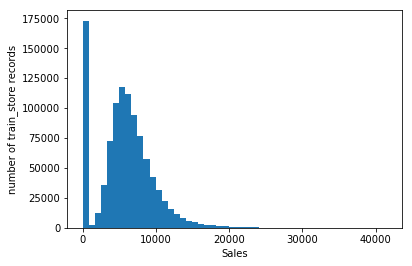

In [25]:
#值得分析的特征有，Sales,Customers,CompetitonDistance.
# Sales
plt.hist(train_store['Sales'].values, bins=50)  
plt.xlabel('Sales')  
plt.ylabel('number of train_store records')  
plt.show()

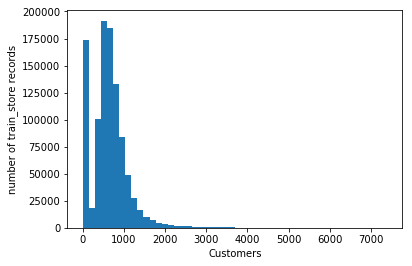

In [26]:
#值得分析的特征有，Sales,Customers,CompetitonDistance.
# Customers
plt.hist(train_store['Customers'].values, bins=50)  
plt.xlabel('Customers')  
plt.ylabel('number of train_store records')  
plt.show()

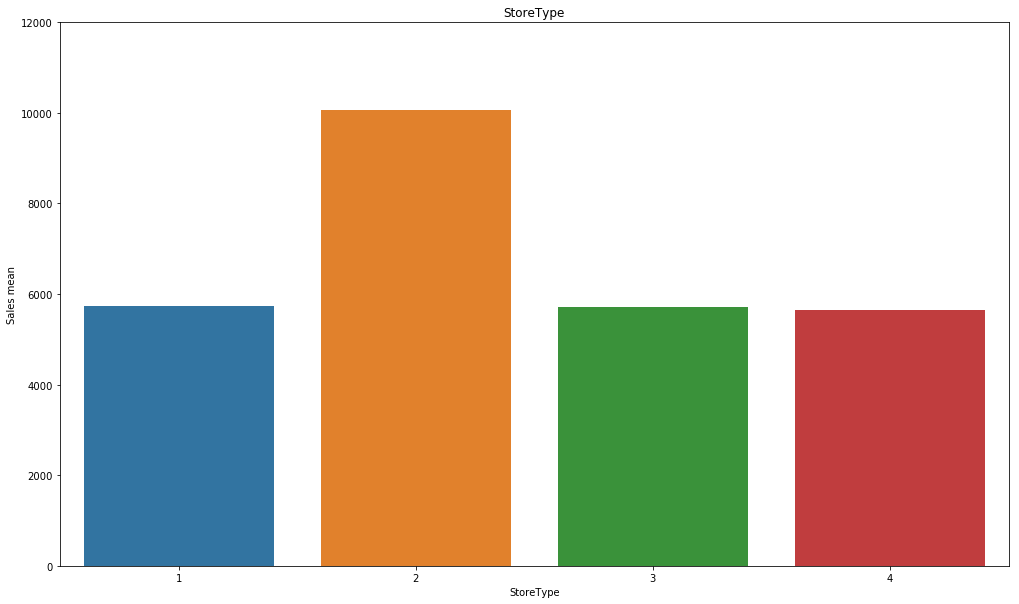

In [29]:
pt = train_store.groupby('StoreType')['Sales'].mean()

plt.subplots(1,1,figsize=(17,10))  
plt.ylim(ymin=0)  
plt.ylim(ymax=12000)  
plt.title('StoreType')  
plt.ylabel('Sales mean')  
sns.barplot(pt.index,pt.values)
plt.show()

In [30]:
# 建立测试函数
def ToWeight(y):
    w = np.zeros(y.shape, dtype=float)
    ind = y != 0
    w[ind] = 1./(y[ind]**2)
    return w


def rmspe(yhat, y):
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean( w * (y - yhat)**2 ))
    return rmspe


def rmspe_xg(yhat, y):
    # y = y.values
    y = y.get_label()
    y = np.exp(y) - 1
    yhat = np.exp(yhat) - 1
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean(w * (y - yhat)**2))
    return "rmspe", rmspe

In [32]:



# 检查测试数据
train_data=train_store.drop(['Sales','Promo2'],axis=1)
train_target=train_store['Sales']
X_train, X_test, y_train, y_test =train_test_split(train_data,train_target, test_size=0.4, random_state=0)
dtrain = xgb.DMatrix(X_train, np.log(y_train + 1))
dvalid = xgb.DMatrix(X_test, np.log(y_test + 1))
dtest = xgb.DMatrix(test)

In [55]:
watchlist = [(dtrain, 'train'),(dvalid, 'eval')]
params = {"objective": ["reg:linear"],
          "eta": [0.2],
          "max_depth": [12],
          "subsample": [0.7],
          "colsample_bytree": [0.7],
          "silent": [1]
          }
num_trees = 2000



# gbm = xgb.train(params, dtrain, num_trees, evals=watchlist, early_stopping_rounds=100, feval=rmspe_xg, verbose_eval=True)

In [57]:
xgb_model=xgb.XGBClassifier()
clf=GridSearchCV(xgb_model,param_grid=params,n_jobs=5,scoring='roc_auc',verbose=2,refit=True)
clf.fit(train_data,train_target)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


C:\ProgramData\Anaconda2\envs\tensorflow\lib\site-packages\sklearn\model_selection\_split.py:597: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


JoblibValueError: JoblibValueError
___________________________________________________________________________
Multiprocessing exception:
...........................................................................
C:\ProgramData\Anaconda2\envs\tensorflow\lib\runpy.py in _run_module_as_main(mod_name='ipykernel_launcher', alter_argv=1)
    188         sys.exit(msg)
    189     main_globals = sys.modules["__main__"].__dict__
    190     if alter_argv:
    191         sys.argv[0] = mod_spec.origin
    192     return _run_code(code, main_globals, None,
--> 193                      "__main__", mod_spec)
        mod_spec = ModuleSpec(name='ipykernel_launcher', loader=<_f...flow\\lib\\site-packages\\ipykernel_launcher.py')
    194 
    195 def run_module(mod_name, init_globals=None,
    196                run_name=None, alter_sys=False):
    197     """Execute a module's code without importing it

...........................................................................
C:\ProgramData\Anaconda2\envs\tensorflow\lib\runpy.py in _run_code(code=<code object <module> at 0x000001B8628D9930, fil...lib\site-packages\ipykernel_launcher.py", line 5>, run_globals={'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': r'C:\ProgramData\Anaconda2\envs\tensorflow\lib\sit...ges\__pycache__\ipykernel_launcher.cpython-36.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': r'C:\ProgramData\Anaconda2\envs\tensorflow\lib\site-packages\ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...flow\\lib\\site-packages\\ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from 'C:\\ProgramD...ow\\lib\\site-packages\\ipykernel\\kernelapp.py'>, ...}, init_globals=None, mod_name='__main__', mod_spec=ModuleSpec(name='ipykernel_launcher', loader=<_f...flow\\lib\\site-packages\\ipykernel_launcher.py'), pkg_name='', script_name=None)
     80                        __cached__ = cached,
     81                        __doc__ = None,
     82                        __loader__ = loader,
     83                        __package__ = pkg_name,
     84                        __spec__ = mod_spec)
---> 85     exec(code, run_globals)
        code = <code object <module> at 0x000001B8628D9930, fil...lib\site-packages\ipykernel_launcher.py", line 5>
        run_globals = {'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': r'C:\ProgramData\Anaconda2\envs\tensorflow\lib\sit...ges\__pycache__\ipykernel_launcher.cpython-36.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': r'C:\ProgramData\Anaconda2\envs\tensorflow\lib\site-packages\ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...flow\\lib\\site-packages\\ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from 'C:\\ProgramD...ow\\lib\\site-packages\\ipykernel\\kernelapp.py'>, ...}
     86     return run_globals
     87 
     88 def _run_module_code(code, init_globals=None,
     89                     mod_name=None, mod_spec=None,

...........................................................................
C:\ProgramData\Anaconda2\envs\tensorflow\lib\site-packages\ipykernel_launcher.py in <module>()
     11     # This is added back by InteractiveShellApp.init_path()
     12     if sys.path[0] == '':
     13         del sys.path[0]
     14 
     15     from ipykernel import kernelapp as app
---> 16     app.launch_new_instance()

...........................................................................
C:\ProgramData\Anaconda2\envs\tensorflow\lib\site-packages\traitlets\config\application.py in launch_instance(cls=<class 'ipykernel.kernelapp.IPKernelApp'>, argv=None, **kwargs={})
    653 
    654         If a global instance already exists, this reinitializes and starts it
    655         """
    656         app = cls.instance(**kwargs)
    657         app.initialize(argv)
--> 658         app.start()
        app.start = <bound method IPKernelApp.start of <ipykernel.kernelapp.IPKernelApp object>>
    659 
    660 #-----------------------------------------------------------------------------
    661 # utility functions, for convenience
    662 #-----------------------------------------------------------------------------

...........................................................................
C:\ProgramData\Anaconda2\envs\tensorflow\lib\site-packages\ipykernel\kernelapp.py in start(self=<ipykernel.kernelapp.IPKernelApp object>)
    472             return self.subapp.start()
    473         if self.poller is not None:
    474             self.poller.start()
    475         self.kernel.start()
    476         try:
--> 477             ioloop.IOLoop.instance().start()
    478         except KeyboardInterrupt:
    479             pass
    480 
    481 launch_new_instance = IPKernelApp.launch_instance

...........................................................................
C:\ProgramData\Anaconda2\envs\tensorflow\lib\site-packages\zmq\eventloop\ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    172             )
    173         return loop
    174     
    175     def start(self):
    176         try:
--> 177             super(ZMQIOLoop, self).start()
        self.start = <bound method ZMQIOLoop.start of <zmq.eventloop.ioloop.ZMQIOLoop object>>
    178         except ZMQError as e:
    179             if e.errno == ETERM:
    180                 # quietly return on ETERM
    181                 pass

...........................................................................
C:\ProgramData\Anaconda2\envs\tensorflow\lib\site-packages\tornado\ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    883                 self._events.update(event_pairs)
    884                 while self._events:
    885                     fd, events = self._events.popitem()
    886                     try:
    887                         fd_obj, handler_func = self._handlers[fd]
--> 888                         handler_func(fd_obj, events)
        handler_func = <function wrap.<locals>.null_wrapper>
        fd_obj = <zmq.sugar.socket.Socket object>
        events = 1
    889                     except (OSError, IOError) as e:
    890                         if errno_from_exception(e) == errno.EPIPE:
    891                             # Happens when the client closes the connection
    892                             pass

...........................................................................
C:\ProgramData\Anaconda2\envs\tensorflow\lib\site-packages\tornado\stack_context.py in null_wrapper(*args=(<zmq.sugar.socket.Socket object>, 1), **kwargs={})
    272         # Fast path when there are no active contexts.
    273         def null_wrapper(*args, **kwargs):
    274             try:
    275                 current_state = _state.contexts
    276                 _state.contexts = cap_contexts[0]
--> 277                 return fn(*args, **kwargs)
        args = (<zmq.sugar.socket.Socket object>, 1)
        kwargs = {}
    278             finally:
    279                 _state.contexts = current_state
    280         null_wrapper._wrapped = True
    281         return null_wrapper

...........................................................................
C:\ProgramData\Anaconda2\envs\tensorflow\lib\site-packages\zmq\eventloop\zmqstream.py in _handle_events(self=<zmq.eventloop.zmqstream.ZMQStream object>, fd=<zmq.sugar.socket.Socket object>, events=1)
    435             # dispatch events:
    436             if events & IOLoop.ERROR:
    437                 gen_log.error("got POLLERR event on ZMQStream, which doesn't make sense")
    438                 return
    439             if events & IOLoop.READ:
--> 440                 self._handle_recv()
        self._handle_recv = <bound method ZMQStream._handle_recv of <zmq.eventloop.zmqstream.ZMQStream object>>
    441                 if not self.socket:
    442                     return
    443             if events & IOLoop.WRITE:
    444                 self._handle_send()

...........................................................................
C:\ProgramData\Anaconda2\envs\tensorflow\lib\site-packages\zmq\eventloop\zmqstream.py in _handle_recv(self=<zmq.eventloop.zmqstream.ZMQStream object>)
    467                 gen_log.error("RECV Error: %s"%zmq.strerror(e.errno))
    468         else:
    469             if self._recv_callback:
    470                 callback = self._recv_callback
    471                 # self._recv_callback = None
--> 472                 self._run_callback(callback, msg)
        self._run_callback = <bound method ZMQStream._run_callback of <zmq.eventloop.zmqstream.ZMQStream object>>
        callback = <function wrap.<locals>.null_wrapper>
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    473                 
    474         # self.update_state()
    475         
    476 

...........................................................................
C:\ProgramData\Anaconda2\envs\tensorflow\lib\site-packages\zmq\eventloop\zmqstream.py in _run_callback(self=<zmq.eventloop.zmqstream.ZMQStream object>, callback=<function wrap.<locals>.null_wrapper>, *args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    409         close our socket."""
    410         try:
    411             # Use a NullContext to ensure that all StackContexts are run
    412             # inside our blanket exception handler rather than outside.
    413             with stack_context.NullContext():
--> 414                 callback(*args, **kwargs)
        callback = <function wrap.<locals>.null_wrapper>
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    415         except:
    416             gen_log.error("Uncaught exception, closing connection.",
    417                           exc_info=True)
    418             # Close the socket on an uncaught exception from a user callback

...........................................................................
C:\ProgramData\Anaconda2\envs\tensorflow\lib\site-packages\tornado\stack_context.py in null_wrapper(*args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    272         # Fast path when there are no active contexts.
    273         def null_wrapper(*args, **kwargs):
    274             try:
    275                 current_state = _state.contexts
    276                 _state.contexts = cap_contexts[0]
--> 277                 return fn(*args, **kwargs)
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    278             finally:
    279                 _state.contexts = current_state
    280         null_wrapper._wrapped = True
    281         return null_wrapper

...........................................................................
C:\ProgramData\Anaconda2\envs\tensorflow\lib\site-packages\ipykernel\kernelbase.py in dispatcher(msg=[<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>])
    278         if self.control_stream:
    279             self.control_stream.on_recv(self.dispatch_control, copy=False)
    280 
    281         def make_dispatcher(stream):
    282             def dispatcher(msg):
--> 283                 return self.dispatch_shell(stream, msg)
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    284             return dispatcher
    285 
    286         for s in self.shell_streams:
    287             s.on_recv(make_dispatcher(s), copy=False)

...........................................................................
C:\ProgramData\Anaconda2\envs\tensorflow\lib\site-packages\ipykernel\kernelbase.py in dispatch_shell(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, msg={'buffers': [], 'content': {'allow_stdin': True, 'code': 'xgb_model=xgb.XGBClassifier()\nclf=GridSearchCV(x...se=2,refit=True)\nclf.fit(train_data,train_target)', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 2, 8, 2, 51, 22, 830508, tzinfo=tzutc()), 'msg_id': '610B16DCF6C54A338E03051EE79CB07F', 'msg_type': 'execute_request', 'session': 'D7DD8401136A428B8337BF59B93F802E', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': '610B16DCF6C54A338E03051EE79CB07F', 'msg_type': 'execute_request', 'parent_header': {}})
    230             self.log.warn("Unknown message type: %r", msg_type)
    231         else:
    232             self.log.debug("%s: %s", msg_type, msg)
    233             self.pre_handler_hook()
    234             try:
--> 235                 handler(stream, idents, msg)
        handler = <bound method Kernel.execute_request of <ipykernel.ipkernel.IPythonKernel object>>
        stream = <zmq.eventloop.zmqstream.ZMQStream object>
        idents = [b'D7DD8401136A428B8337BF59B93F802E']
        msg = {'buffers': [], 'content': {'allow_stdin': True, 'code': 'xgb_model=xgb.XGBClassifier()\nclf=GridSearchCV(x...se=2,refit=True)\nclf.fit(train_data,train_target)', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 2, 8, 2, 51, 22, 830508, tzinfo=tzutc()), 'msg_id': '610B16DCF6C54A338E03051EE79CB07F', 'msg_type': 'execute_request', 'session': 'D7DD8401136A428B8337BF59B93F802E', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': '610B16DCF6C54A338E03051EE79CB07F', 'msg_type': 'execute_request', 'parent_header': {}}
    236             except Exception:
    237                 self.log.error("Exception in message handler:", exc_info=True)
    238             finally:
    239                 self.post_handler_hook()

...........................................................................
C:\ProgramData\Anaconda2\envs\tensorflow\lib\site-packages\ipykernel\kernelbase.py in execute_request(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, ident=[b'D7DD8401136A428B8337BF59B93F802E'], parent={'buffers': [], 'content': {'allow_stdin': True, 'code': 'xgb_model=xgb.XGBClassifier()\nclf=GridSearchCV(x...se=2,refit=True)\nclf.fit(train_data,train_target)', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 2, 8, 2, 51, 22, 830508, tzinfo=tzutc()), 'msg_id': '610B16DCF6C54A338E03051EE79CB07F', 'msg_type': 'execute_request', 'session': 'D7DD8401136A428B8337BF59B93F802E', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': '610B16DCF6C54A338E03051EE79CB07F', 'msg_type': 'execute_request', 'parent_header': {}})
    394         if not silent:
    395             self.execution_count += 1
    396             self._publish_execute_input(code, parent, self.execution_count)
    397 
    398         reply_content = self.do_execute(code, silent, store_history,
--> 399                                         user_expressions, allow_stdin)
        user_expressions = {}
        allow_stdin = True
    400 
    401         # Flush output before sending the reply.
    402         sys.stdout.flush()
    403         sys.stderr.flush()

...........................................................................
C:\ProgramData\Anaconda2\envs\tensorflow\lib\site-packages\ipykernel\ipkernel.py in do_execute(self=<ipykernel.ipkernel.IPythonKernel object>, code='xgb_model=xgb.XGBClassifier()\nclf=GridSearchCV(x...se=2,refit=True)\nclf.fit(train_data,train_target)', silent=False, store_history=True, user_expressions={}, allow_stdin=True)
    191 
    192         self._forward_input(allow_stdin)
    193 
    194         reply_content = {}
    195         try:
--> 196             res = shell.run_cell(code, store_history=store_history, silent=silent)
        res = undefined
        shell.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = 'xgb_model=xgb.XGBClassifier()\nclf=GridSearchCV(x...se=2,refit=True)\nclf.fit(train_data,train_target)'
        store_history = True
        silent = False
    197         finally:
    198             self._restore_input()
    199 
    200         if res.error_before_exec is not None:

...........................................................................
C:\ProgramData\Anaconda2\envs\tensorflow\lib\site-packages\ipykernel\zmqshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, *args=('xgb_model=xgb.XGBClassifier()\nclf=GridSearchCV(x...se=2,refit=True)\nclf.fit(train_data,train_target)',), **kwargs={'silent': False, 'store_history': True})
    528             )
    529         self.payload_manager.write_payload(payload)
    530 
    531     def run_cell(self, *args, **kwargs):
    532         self._last_traceback = None
--> 533         return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
        self.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        args = ('xgb_model=xgb.XGBClassifier()\nclf=GridSearchCV(x...se=2,refit=True)\nclf.fit(train_data,train_target)',)
        kwargs = {'silent': False, 'store_history': True}
    534 
    535     def _showtraceback(self, etype, evalue, stb):
    536         # try to preserve ordering of tracebacks and print statements
    537         sys.stdout.flush()

...........................................................................
C:\ProgramData\Anaconda2\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell='xgb_model=xgb.XGBClassifier()\nclf=GridSearchCV(x...se=2,refit=True)\nclf.fit(train_data,train_target)', store_history=True, silent=False, shell_futures=True)
   2693                 self.displayhook.exec_result = result
   2694 
   2695                 # Execute the user code
   2696                 interactivity = "none" if silent else self.ast_node_interactivity
   2697                 has_raised = self.run_ast_nodes(code_ast.body, cell_name,
-> 2698                    interactivity=interactivity, compiler=compiler, result=result)
        interactivity = 'last_expr'
        compiler = <IPython.core.compilerop.CachingCompiler object>
   2699                 
   2700                 self.last_execution_succeeded = not has_raised
   2701 
   2702                 # Reset this so later displayed values do not modify the

...........................................................................
C:\ProgramData\Anaconda2\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py in run_ast_nodes(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, nodelist=[<_ast.Assign object>, <_ast.Assign object>, <_ast.Expr object>], cell_name='<ipython-input-57-e6896900fd90>', interactivity='last', compiler=<IPython.core.compilerop.CachingCompiler object>, result=<ExecutionResult object at 1b800b01ac8, executio..._before_exec=None error_in_exec=None result=None>)
   2803                     return True
   2804 
   2805             for i, node in enumerate(to_run_interactive):
   2806                 mod = ast.Interactive([node])
   2807                 code = compiler(mod, cell_name, "single")
-> 2808                 if self.run_code(code, result):
        self.run_code = <bound method InteractiveShell.run_code of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = <code object <module> at 0x000001B800732B70, file "<ipython-input-57-e6896900fd90>", line 3>
        result = <ExecutionResult object at 1b800b01ac8, executio..._before_exec=None error_in_exec=None result=None>
   2809                     return True
   2810 
   2811             # Flush softspace
   2812             if softspace(sys.stdout, 0):

...........................................................................
C:\ProgramData\Anaconda2\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py in run_code(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, code_obj=<code object <module> at 0x000001B800732B70, file "<ipython-input-57-e6896900fd90>", line 3>, result=<ExecutionResult object at 1b800b01ac8, executio..._before_exec=None error_in_exec=None result=None>)
   2857         outflag = True  # happens in more places, so it's easier as default
   2858         try:
   2859             try:
   2860                 self.hooks.pre_run_code_hook()
   2861                 #rprint('Running code', repr(code_obj)) # dbg
-> 2862                 exec(code_obj, self.user_global_ns, self.user_ns)
        code_obj = <code object <module> at 0x000001B800732B70, file "<ipython-input-57-e6896900fd90>", line 3>
        self.user_global_ns = {'GridSearchCV': <class 'sklearn.model_selection._search.GridSearchCV'>, 'Imputer': <class 'sklearn.preprocessing.imputation.Imputer'>, 'In': ['', 'import numpy as np\nimport pandas as pd\nimport ma...\nfrom sklearn.model_selection import GridSearchCV', "train = pd.read_csv('../input/train.csv',dtype={...ore.csv')\ntest = pd.read_csv('../input/test.csv')", "pd.set_option('display.float_format', lambda x: '%.3f' % x)  \ntrain.info()\ntest.info()\nstore.info()", '#首先整理test数据\n#展现Open为nan的数据\n# print(test.query(\'O...test["StateHoliday"].value_counts())\n\ntest.info()', "#接着整理store数据\n\n#把Assortment整理为a:1,b:2,c:3\nstore.l...tore['Promo2SinceYear'].astype(int)\n\nstore.info()", "#处理PromoInterval\nprint(store['PromoInterval'].va...e['PromoInterval'].fillna('0,0,0,0')\nstore.head()", '# 将PromoInterval展开\nPromoInterval1=[]\nPromoInterv...rval4)\n        \nstore.info()            \n        ', "# 将PromoInterval1，PromoInterval2，PromoInterval3，...print(store['PromoIntervalMonth'].value_counts())", "#整理train数据\n# print(train.info())\ntrain['Date']=p...'StateHoliday'].astype(int)\n\n\nprint(train.info())", "# 将train数据和store数据合并\ntrain_store=pd.merge(train,...['Store'],right_on=['Store'])\n\ntrain_store.info()", "print(len(train_store.query('Promo2==0')[['Store...rint(len(train_store))\n\ntrain_store['Promoing']=0", "#总数1017209\n#开始清洗\n#标记出正在参与Promo的记录\n# train_store....omoing']=1\ntrain_store['Promoing'].value_counts()", "#去掉不必要的或者重复的特征\ntrain_store.info()\ntrain_store.dr...ceYear',axis=1, inplace=True)\n\ntrain_store.info()", '#整理的目标总数为1017209\ntrain_store=train_store.drop_duplicates()\nprint(len(train_store))', "# 整理Promoing特征并去重\ntemp_train_store=train_store.q...'Promoing'].astype(int)\nprint(train_store.info())", "#添加是否有竞争对手信息，然后删除竞争对手开始时间年/月\ntrain_store['IsComp...nceYear'],axis=1,inplace=True)\ntrain_store.info()", "# 合并test\ntest_store=pd.merge(test,store,how='inn...re'])\nprint(test.info())\nprint(test_store.info())", "test_store=test_store.drop_duplicates()\nprint(le...ceYear'],axis=1, inplace=True)\n\ntest_store.info()", 'test_store=test_store.drop_duplicates()\nprint(len(test_store))\n#目标是整理出41088条记录', ...], 'Out': {6:    Store  StoreType  Assortment  CompetitionDist...               0                0       0,0,0,0  , 12: 0    2369951
1     174792
Name: Promoing, dtype: int64, 23: False}, 'PromoInterval1': ['0', '1', '1', '0', '0', '0', '0', '0', '0', '0', '1', '1', '2', '1', '1', '0', '1', '1', '3', '1', ...], 'PromoInterval2': ['0', '4', '4', '0', '0', '0', '0', '0', '0', '0', '4', '4', '5', '4', '4', '0', '4', '4', '6', '4', ...], 'PromoInterval3': ['0', '7', '7', '0', '0', '0', '0', '0', '0', '0', '7', '7', '8', '7', '7', '0', '7', '7', '9', '7', ...], 'PromoInterval4': ['0', '10', '10', '0', '0', '0', '0', '0', '0', '0', '10', '10', '11', '10', '10', '0', '10', '10', '12', '10', ...], 'StandardScaler': <class 'sklearn.preprocessing.data.StandardScaler'>, 'StratifiedKFold': <class 'sklearn.model_selection._split.StratifiedKFold'>, ...}
        self.user_ns = {'GridSearchCV': <class 'sklearn.model_selection._search.GridSearchCV'>, 'Imputer': <class 'sklearn.preprocessing.imputation.Imputer'>, 'In': ['', 'import numpy as np\nimport pandas as pd\nimport ma...\nfrom sklearn.model_selection import GridSearchCV', "train = pd.read_csv('../input/train.csv',dtype={...ore.csv')\ntest = pd.read_csv('../input/test.csv')", "pd.set_option('display.float_format', lambda x: '%.3f' % x)  \ntrain.info()\ntest.info()\nstore.info()", '#首先整理test数据\n#展现Open为nan的数据\n# print(test.query(\'O...test["StateHoliday"].value_counts())\n\ntest.info()', "#接着整理store数据\n\n#把Assortment整理为a:1,b:2,c:3\nstore.l...tore['Promo2SinceYear'].astype(int)\n\nstore.info()", "#处理PromoInterval\nprint(store['PromoInterval'].va...e['PromoInterval'].fillna('0,0,0,0')\nstore.head()", '# 将PromoInterval展开\nPromoInterval1=[]\nPromoInterv...rval4)\n        \nstore.info()            \n        ', "# 将PromoInterval1，PromoInterval2，PromoInterval3，...print(store['PromoIntervalMonth'].value_counts())", "#整理train数据\n# print(train.info())\ntrain['Date']=p...'StateHoliday'].astype(int)\n\n\nprint(train.info())", "# 将train数据和store数据合并\ntrain_store=pd.merge(train,...['Store'],right_on=['Store'])\n\ntrain_store.info()", "print(len(train_store.query('Promo2==0')[['Store...rint(len(train_store))\n\ntrain_store['Promoing']=0", "#总数1017209\n#开始清洗\n#标记出正在参与Promo的记录\n# train_store....omoing']=1\ntrain_store['Promoing'].value_counts()", "#去掉不必要的或者重复的特征\ntrain_store.info()\ntrain_store.dr...ceYear',axis=1, inplace=True)\n\ntrain_store.info()", '#整理的目标总数为1017209\ntrain_store=train_store.drop_duplicates()\nprint(len(train_store))', "# 整理Promoing特征并去重\ntemp_train_store=train_store.q...'Promoing'].astype(int)\nprint(train_store.info())", "#添加是否有竞争对手信息，然后删除竞争对手开始时间年/月\ntrain_store['IsComp...nceYear'],axis=1,inplace=True)\ntrain_store.info()", "# 合并test\ntest_store=pd.merge(test,store,how='inn...re'])\nprint(test.info())\nprint(test_store.info())", "test_store=test_store.drop_duplicates()\nprint(le...ceYear'],axis=1, inplace=True)\n\ntest_store.info()", 'test_store=test_store.drop_duplicates()\nprint(len(test_store))\n#目标是整理出41088条记录', ...], 'Out': {6:    Store  StoreType  Assortment  CompetitionDist...               0                0       0,0,0,0  , 12: 0    2369951
1     174792
Name: Promoing, dtype: int64, 23: False}, 'PromoInterval1': ['0', '1', '1', '0', '0', '0', '0', '0', '0', '0', '1', '1', '2', '1', '1', '0', '1', '1', '3', '1', ...], 'PromoInterval2': ['0', '4', '4', '0', '0', '0', '0', '0', '0', '0', '4', '4', '5', '4', '4', '0', '4', '4', '6', '4', ...], 'PromoInterval3': ['0', '7', '7', '0', '0', '0', '0', '0', '0', '0', '7', '7', '8', '7', '7', '0', '7', '7', '9', '7', ...], 'PromoInterval4': ['0', '10', '10', '0', '0', '0', '0', '0', '0', '0', '10', '10', '11', '10', '10', '0', '10', '10', '12', '10', ...], 'StandardScaler': <class 'sklearn.preprocessing.data.StandardScaler'>, 'StratifiedKFold': <class 'sklearn.model_selection._split.StratifiedKFold'>, ...}
   2863             finally:
   2864                 # Reset our crash handler in place
   2865                 sys.excepthook = old_excepthook
   2866         except SystemExit as e:

...........................................................................
D:\Excellent\python\ml-advanced\ForecastRossmannStoreSales\script\<ipython-input-57-e6896900fd90> in <module>()
      1 xgb_model=xgb.XGBClassifier()
      2 clf=GridSearchCV(xgb_model,param_grid=params,n_jobs=5,scoring='roc_auc',verbose=2,refit=True)
----> 3 clf.fit(train_data,train_target)

...........................................................................
C:\ProgramData\Anaconda2\envs\tensorflow\lib\site-packages\sklearn\model_selection\_search.py in fit(self=GridSearchCV(cv=None, error_score='raise',
     ..._score=True,
       scoring='roc_auc', verbose=2), X=         Store  DayOfWeek  Customers  Open  Prom...  0              1  

[1017209 rows x 16 columns], y=0          5263
1          5020
2          4782
...     0
Name: Sales, Length: 1017209, dtype: int64, groups=None, **fit_params={})
    633                                   return_train_score=self.return_train_score,
    634                                   return_n_test_samples=True,
    635                                   return_times=True, return_parameters=False,
    636                                   error_score=self.error_score)
    637           for parameters, (train, test) in product(candidate_params,
--> 638                                                    cv.split(X, y, groups)))
        cv.split = <bound method StratifiedKFold.split of Stratifie...ld(n_splits=3, random_state=None, shuffle=False)>
        X =          Store  DayOfWeek  Customers  Open  Prom...  0              1  

[1017209 rows x 16 columns]
        y = 0          5263
1          5020
2          4782
...     0
Name: Sales, Length: 1017209, dtype: int64
        groups = None
    639 
    640         # if one choose to see train score, "out" will contain train score info
    641         if self.return_train_score:
    642             (train_score_dicts, test_score_dicts, test_sample_counts, fit_time,

...........................................................................
C:\ProgramData\Anaconda2\envs\tensorflow\lib\site-packages\sklearn\externals\joblib\parallel.py in __call__(self=Parallel(n_jobs=5), iterable=<generator object BaseSearchCV.fit.<locals>.<genexpr>>)
    784             if pre_dispatch == "all" or n_jobs == 1:
    785                 # The iterable was consumed all at once by the above for loop.
    786                 # No need to wait for async callbacks to trigger to
    787                 # consumption.
    788                 self._iterating = False
--> 789             self.retrieve()
        self.retrieve = <bound method Parallel.retrieve of Parallel(n_jobs=5)>
    790             # Make sure that we get a last message telling us we are done
    791             elapsed_time = time.time() - self._start_time
    792             self._print('Done %3i out of %3i | elapsed: %s finished',
    793                         (len(self._output), len(self._output),

---------------------------------------------------------------------------
Sub-process traceback:
---------------------------------------------------------------------------
ValueError                                         Thu Feb  8 10:53:13 2018
PID: 5692 Python 3.6.2: C:\ProgramData\Anaconda2\envs\tensorflow\python.exe
...........................................................................
C:\ProgramData\Anaconda2\envs\tensorflow\lib\site-packages\sklearn\externals\joblib\parallel.py in __call__(self=<sklearn.externals.joblib.parallel.BatchedCalls object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        self.items = [(<function _fit_and_score>, (XGBClassifier(base_score=0.5, booster='gbtree', ...ht=1, seed=None,
       silent=True, subsample=1),          Store  DayOfWeek  Customers  Open  Prom...  0              1  

[1017209 rows x 16 columns], 0          5263
1          5020
2          4782
...     0
Name: Sales, Length: 1017209, dtype: int64, {'score': make_scorer(roc_auc_score, needs_threshold=True)}, memmap([  31716,   37851,   74495, ..., 1017206, 1017207, 1017208]), memmap([      0,       1,       2, ..., 1016235, 1016255, 1016260]), 2, {'colsample_bytree': 0.7, 'eta': 0.2, 'max_depth': 12, 'objective': 'reg:linear', 'silent': 1, 'subsample': 0.7}), {'error_score': 'raise', 'fit_params': {}, 'return_n_test_samples': True, 'return_parameters': False, 'return_times': True, 'return_train_score': True})]
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
C:\ProgramData\Anaconda2\envs\tensorflow\lib\site-packages\sklearn\externals\joblib\parallel.py in <listcomp>(.0=<list_iterator object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        func = <function _fit_and_score>
        args = (XGBClassifier(base_score=0.5, booster='gbtree', ...ht=1, seed=None,
       silent=True, subsample=1),          Store  DayOfWeek  Customers  Open  Prom...  0              1  

[1017209 rows x 16 columns], 0          5263
1          5020
2          4782
...     0
Name: Sales, Length: 1017209, dtype: int64, {'score': make_scorer(roc_auc_score, needs_threshold=True)}, memmap([  31716,   37851,   74495, ..., 1017206, 1017207, 1017208]), memmap([      0,       1,       2, ..., 1016235, 1016255, 1016260]), 2, {'colsample_bytree': 0.7, 'eta': 0.2, 'max_depth': 12, 'objective': 'reg:linear', 'silent': 1, 'subsample': 0.7})
        kwargs = {'error_score': 'raise', 'fit_params': {}, 'return_n_test_samples': True, 'return_parameters': False, 'return_times': True, 'return_train_score': True}
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
C:\ProgramData\Anaconda2\envs\tensorflow\lib\site-packages\sklearn\model_selection\_validation.py in _fit_and_score(estimator=XGBClassifier(base_score=0.5, booster='gbtree', ...ht=1, seed=None,
       silent=True, subsample=1), X=         Store  DayOfWeek  Customers  Open  Prom...  0              1  

[1017209 rows x 16 columns], y=0          5263
1          5020
2          4782
...     0
Name: Sales, Length: 1017209, dtype: int64, scorer={'score': make_scorer(roc_auc_score, needs_threshold=True)}, train=memmap([  31716,   37851,   74495, ..., 1017206, 1017207, 1017208]), test=memmap([      0,       1,       2, ..., 1016235, 1016255, 1016260]), verbose=2, parameters={'colsample_bytree': 0.7, 'eta': 0.2, 'max_depth': 12, 'objective': 'reg:linear', 'silent': 1, 'subsample': 0.7}, fit_params={}, return_train_score=True, return_parameters=False, return_n_test_samples=True, return_times=True, error_score='raise')
    418                       for k, v in fit_params.items()])
    419 
    420     test_scores = {}
    421     train_scores = {}
    422     if parameters is not None:
--> 423         estimator.set_params(**parameters)
        estimator.set_params = <bound method BaseEstimator.set_params of XGBCla...t=1, seed=None,
       silent=True, subsample=1)>
        parameters = {'colsample_bytree': 0.7, 'eta': 0.2, 'max_depth': 12, 'objective': 'reg:linear', 'silent': 1, 'subsample': 0.7}
    424 
    425     start_time = time.time()
    426 
    427     X_train, y_train = _safe_split(estimator, X, y, train)

...........................................................................
C:\ProgramData\Anaconda2\envs\tensorflow\lib\site-packages\sklearn\base.py in set_params(self=XGBClassifier(base_score=0.5, booster='gbtree', ...ht=1, seed=None,
       silent=True, subsample=1), **params={'colsample_bytree': 0.7, 'eta': 0.2, 'max_depth': 12, 'objective': 'reg:linear', 'silent': 1, 'subsample': 0.7})
    278                 # simple objects case
    279                 if key not in valid_params:
    280                     raise ValueError('Invalid parameter %s for estimator %s. '
    281                                      'Check the list of available parameters '
    282                                      'with `estimator.get_params().keys()`.' %
--> 283                                      (key, self.__class__.__name__))
        key = 'eta'
        self.__class__.__name__ = 'XGBClassifier'
    284                 setattr(self, key, value)
    285         return self
    286 
    287     def __repr__(self):

ValueError: Invalid parameter eta for estimator XGBClassifier. Check the list of available parameters with `estimator.get_params().keys()`.
___________________________________________________________________________

In [ ]:
best_parameters,score,_=max(clf.grid_scores_,key=lambda x:x[1])
print('Raw AUC score:',score)


In [29]:
# 切割x和y


# X_train=X_train.as_matrix()
# X_test=X_test.as_matrix()

In [30]:

gbm1.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [31]:
predictions_test=gbm.predict(X_test)

In [35]:
# def rmspe(y, yhat):
#     return np.sqrt(np.mean((yhat/y-1) ** 2))
# np.log1p(X_valid.Sales)
print(np.expm1(predictions_test))

[ inf  inf  inf ...,  inf  inf  inf]


C:\ProgramData\Anaconda2\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in expm1
  after removing the cwd from sys.path.


In [33]:
error = rmspe(y_test.values, np.expm1(predictions_test))
print('RMSPE: {:.6f}'.format(error))

NameError: name 'rmspe' is not defined

In [64]:
print(predictions_test)
error = rmspe(np.exp(predictions_test) - 1, y_test.values)
print('error', error)

[ 3823.72436523  7105.19628906  6492.51904297 ...,  8516.38867188
  6126.64501953  5398.74462891]
error nan


C:\ProgramData\Anaconda2\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  
C:\ProgramData\Anaconda2\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in multiply
  # Remove the CWD from sys.path while we load stuff.


In [43]:
# submission = pd.DataFrame({'Id': test['Id'],
#                             'Sales': predictions})
# print(submission)
# submission.to_csv("submission.csv",index=False)


          Id        Sales
0          1   292.636566
1          2   204.852600
2          3   638.279968
3          4   638.279968
4          5   184.572479
5          6   184.572479
6          7   184.572479
7          8   184.572479
8          9   168.790024
9         10   168.790024
10        11   168.790024
11        12   184.572479
12        13   236.286469
13        14   701.281372
14        15   701.281372
15        16   739.727661
16        17   739.727661
17        18  1011.719849
18        19   533.091797
19        20   457.074402
20        21   312.416504
21        22   292.313629
22        23   159.091782
23        24   159.091782
24        25   159.091782
25        26   174.874237
26        27   174.874237
27        28   644.364136
28        29   644.364136
29        30   628.581726
...      ...          ...
41058  41059   817.333374
41059  41060   835.933716
41060  41061   741.516785
41061  41062   721.413879
41062  41063   669.740845
41063  41064   669.740845
41064  41065

### 检查正确率

### 处理数据

In [118]:
#看看有没有open为0但是有销售数据的
new_train.query('Open==0 & Sales>0')
#看看销售数据的情况
new_train["Sales"].describe()
# 看看节假日有哪些
new_train["StateHoliday"].drop_duplicates()
#各个StateHolitday的数据值类型 
new_train["StateHoliday"].value_counts()

NameError: name 'new_train' is not defined

In [11]:
new_train.query('Open==0 & Sales>0')
new_train.query('Open==1 & StateHoliday=="c"')['Date'].value_counts()

12/26/2013    19
12/26/2014    19
12/25/2013    17
12/25/2014    16
Name: Date, dtype: int64

In [12]:
new_train.query('Open==0 & SchoolHoliday=="1"')[['Date','Store']]

new_train.query('Store==1')

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,7/31/2015,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,1,4,7/30/2015,5020,546,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
2,1,3,7/29/2015,4782,523,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
3,1,2,7/28/2015,5011,560,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
4,1,1,7/27/2015,6102,612,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
5,1,7,7/26/2015,0,0,0,0,0,0,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
6,1,6,7/25/2015,4364,500,1,0,0,0,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
7,1,5,7/24/2015,3706,459,1,0,0,0,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
8,1,4,7/23/2015,3769,503,1,0,0,0,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
9,1,3,7/22/2015,3464,463,1,0,0,0,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN


In [13]:
#根据常识我觉得客户数和销售量的关系应该很大
#添加一个月份
t=new_train['Date'].str.split('/')
month=[]

for m in t: 
    month.append(m[0])

new_train['Month']=pd.to_numeric(pd.Series(month))

new_train.info()

new_train['Month'].value_counts()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 19 columns):
Store                        1017209 non-null int64
DayOfWeek                    1017209 non-null int64
Date                         1017209 non-null object
Sales                        1017209 non-null int64
Customers                    1017209 non-null int64
Open                         1017209 non-null int64
Promo                        1017209 non-null int64
StateHoliday                 1017209 non-null object
SchoolHoliday                1017209 non-null int64
StoreType                    1017209 non-null object
Assortment                   1017209 non-null object
CompetitionDistance          1014567 non-null float64
CompetitionOpenSinceMonth    693861 non-null float64
CompetitionOpenSinceYear     693861 non-null float64
Promo2                       1017209 non-null int64
Promo2SinceWeek              509178 non-null float64
Promo2SinceYear              509178 non-null f

5     103695
3     103695
1     103694
6     100350
4     100350
7      98115
2      93660
12     63550
10     63550
8      63550
11     61500
9      61500
Name: Month, dtype: int64

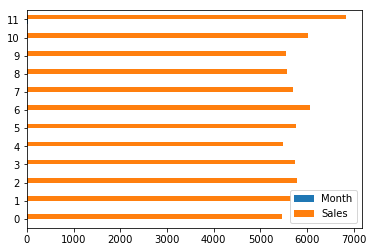

In [46]:
# 按月份sum销售额
new_train[['Month','Sales']].groupby('Month',as_index=False).mean().sort_values('Month')
month_sales=new_train[['Month','Sales']].groupby('Month',as_index=False).mean().sort_values('Month')
month_sales.plot(kind='barh',rot=0)
plt.show()

In [43]:
data_counts=new_train['Date'].value_counts()
print(len(data_counts))
# data_counts.plot(kind='barh',rot=0)
# plt.show()

942


### 单变量分析

TypeError: unhashable type: 'slice'

### 测试xgboost模型

In [15]:
model = XGBClassifier()